<a href="https://colab.research.google.com/github/ahmedhazemfekry/Products-Classificarion-Neural-Network/blob/dev/Products_Classifying_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Loading Data


In [0]:
import pandas as pd
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

#Loading Data
data = pd.read_csv("Data_With_Category.csv") 
data = data.dropna(subset=['Product'])
data = data.drop_duplicates(subset=['Product'])

train_data = data["Product"].tolist()
train_labels = data["Product type"].tolist()


In [0]:
def get_Labels(l):
    Labels_List = []
    Categories  = []
    for Category in l:
        if Category in Categories:
            Labels_List.append(Categories.index(Category))
        else:
            Categories.append(Category)
            Labels_List.append(Categories.index(Category))
    return Labels_List, Categories
  
labels, classes = get_Labels(train_labels)

def get_classes(l):
  list = np.zeros([144, 21])
  for idx,item in enumerate(labels):
    x = np.zeros(21)
    x[item]=1
    list[idx]=x
  return list
   
targets = get_classes(labels)


In [10]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 144, labels: 144


In [0]:
#@title Pre-Processing of Data 


In [11]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

>  **Convert Names to Vectors**

In [0]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(train_data)]

max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

In [0]:
#@title Converting a Product Name to Vector function


In [94]:
def ConvertProductName(name):
    model= Doc2Vec.load("d2v.model")
    #to find the vector of a document which is not in training data
    test_data = word_tokenize(name.lower())
    v1 = model.infer_vector(test_data)
    #print("V1_infer", v1)

    # to find most similar doc using tags
    # similar_doc = model.docvecs.most_similar('1')
    return v1
  
def get_Product_Vectors(l):
    Vectors_List = np.zeros([144,20])
    for idx in range(144):
        Vectors_List[idx]=l[idx]
    return Vectors_List

data = get_Product_Vectors(model.docvecs)
data

array([[-1.09431422, -0.25098208,  0.37261838, ...,  0.43428639,
         0.33644974,  0.58467174],
       [-0.70218217,  0.67952943,  0.25148463, ...,  0.12124254,
        -0.38585401,  0.15318863],
       [-0.63633358, -0.44368315,  0.81650734, ...,  0.7322666 ,
        -0.51216257,  1.2440691 ],
       ...,
       [-1.14238715, -0.22626844,  0.4471513 , ...,  0.08260925,
         0.37470025,  0.56833804],
       [-0.86706245, -0.18053859, -0.1601737 , ...,  0.45622188,
         0.0440066 ,  1.44778895],
       [-0.67403197,  0.13912815, -0.03314321, ...,  0.51565164,
        -0.28113881,  1.19878948]])

In [0]:
#@title Building The Model


In [0]:
# keras.datasets.imdb is broken in 1.13 and 1.14, by np 1.16.3
!pip install tf_nightly
!pip install -q pyyaml  # Required to save models in YAML format

In [2]:
import tensorflow as tf
from tensorflow.keras import layers

print(tf.VERSION)
print(tf.keras.__version__)

1.14.1-dev20190501
2.2.4-tf


In [189]:
ML_model = tf.keras.Sequential([
# Adds a densely-connected layer with 64 units to the model:
layers.Dense(64, activation='relu', input_shape=(20,)),
# Add another:
layers.Dense(64, activation='relu'),
# Add a softmax layer with 10 output units:
layers.Dense(21, activation='softmax')])

ML_model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

train_data = data[0:120]
train_labels = targets[0:120]

test_data = data[121:131]
test_labels = targets[121:131]

val_data = data[132:143]
val_labels = targets[132:143]

history = ML_model.fit(train_data, train_labels, epochs=40, batch_size=30,
          validation_data=(val_data, val_labels), verbose=1)



Train on 120 samples, validate on 11 samples
Epoch 1/40
120/120 [==============================] - 1s 10ms/sample - loss: 3.1185 - acc: 0.0417 - val_loss: 3.2872 - val_acc: 0.0000e+00
Epoch 2/40
120/120 [==============================] - 0s 233us/sample - loss: 3.0447 - acc: 0.0667 - val_loss: 3.2413 - val_acc: 0.0000e+00
Epoch 3/40
120/120 [==============================] - 0s 203us/sample - loss: 2.9845 - acc: 0.0833 - val_loss: 3.2077 - val_acc: 0.0000e+00
Epoch 4/40
120/120 [==============================] - 0s 228us/sample - loss: 2.9305 - acc: 0.1250 - val_loss: 3.1732 - val_acc: 0.0000e+00
Epoch 5/40
120/120 [==============================] - 0s 206us/sample - loss: 2.8800 - acc: 0.1417 - val_loss: 3.1411 - val_acc: 0.0000e+00
Epoch 6/40
120/120 [==============================] - 0s 203us/sample - loss: 2.8314 - acc: 0.2250 - val_loss: 3.1089 - val_acc: 0.0000e+00
Epoch 7/40
120/120 [==============================] - 0s 190us/sample - loss: 2.7821 - acc: 0.3000 - val_loss: 3.079

In [190]:
results = ML_model.evaluate(test_data, test_labels)

10/10 [==============================] - 0s 748us/sample - loss: 1.6977 - acc: 0.6000


In [191]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

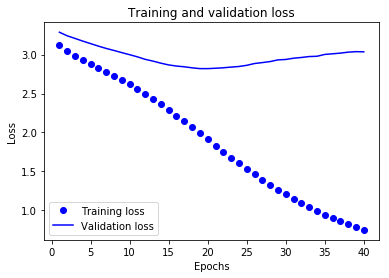

In [192]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

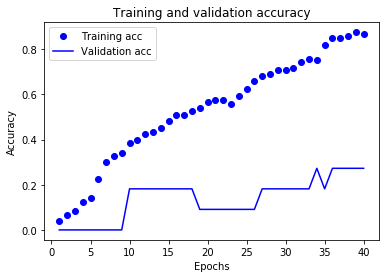

In [193]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [196]:
result = ML_model.predict(train_data, batch_size=32)
result

array([[8.1885356e-01, 8.2471088e-05, 5.8593749e-05, ..., 6.2247488e-04,
        1.1919680e-03, 3.5645504e-04],
       [8.2770461e-01, 2.3556428e-04, 4.3808308e-05, ..., 1.9333364e-05,
        2.1115673e-05, 2.5484373e-04],
       [6.4606592e-04, 4.4429326e-01, 5.4820087e-02, ..., 1.8295489e-03,
        5.9993491e-03, 7.2238292e-03],
       ...,
       [6.8632285e-03, 2.5354067e-05, 2.3197508e-04, ..., 1.5809560e-03,
        3.0306945e-04, 2.9145210e-04],
       [3.8206717e-03, 2.2938944e-05, 1.9317126e-04, ..., 5.9938652e-04,
        7.8379948e-05, 3.7882899e-04],
       [6.7381516e-02, 1.5452403e-03, 2.2502569e-03, ..., 6.0799718e-03,
        4.6335841e-03, 4.3110698e-03]], dtype=float32)